In [1]:
import numpy as np
import seaborn
import wave
import os
import matplotlib.pyplot as plt
from scipy import signal
import librosa

In [2]:
data_dir = '../data/Audio_Speech_Actors_01-24/Actor_01'
data_file = '03-01-01-01-01-01-01.wav'

data_path = os.path.join(data_dir, data_file)

In [3]:
#samples, sample_rate = sf.read(data_path)
samples, _ = librosa.load(data_path)
wave_reader = wave.open(data_path)
sample_rate = wave_reader.getframerate()

In [4]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5,0,'Seconds')

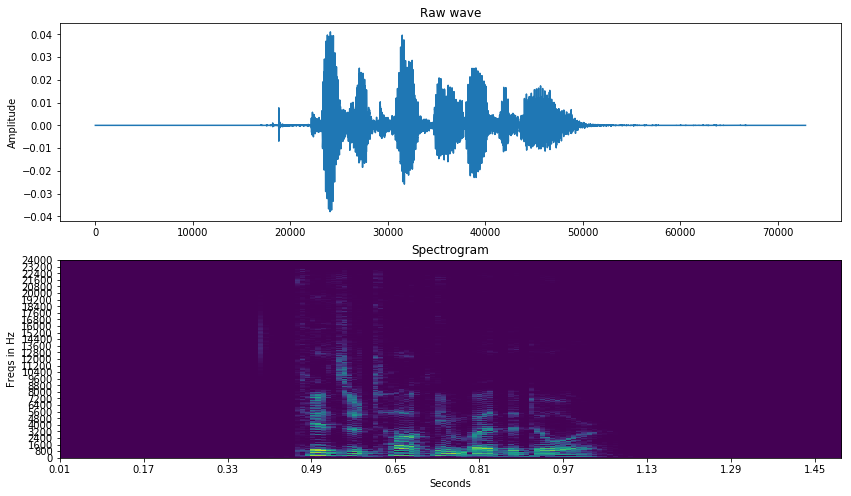

In [5]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_ylabel('Amplitude')
ax1.plot(samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')